In [1]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import scikit_posthocs as sp
import sys

from mpl_toolkits.mplot3d import axes3d

In [2]:
AllName="dataG.pkl"
ResizesName="dataM.pkl"
matrixIt="dataL.pkl"
matrixIt_Total="data_L_Total.csv"
n_cores=20
repet = 5 #CAMBIAR EL NUMERO SEGUN NUMERO DE EJECUCIONES POR CONFIG

p_value = 0.05
processes = [2,10,20,40,80,120,160]

positions = [321, 322, 323, 324, 325]
positions_small = [221, 222, 223, 224]

labels = ['(1,10)',   '(1,20)',   '(1,40)',  '(1,80)',  '(1,120)','(1,160)',
            '(10,1)', '(10,20)',  '(10,40)', '(10,80)', '(10,120)','(10,160)',
            '(20,1)', '(20,10)',  '(20,40)', '(20,80)', '(20,120)','(20,160)',
            '(40,1)', '(40,10)',  '(40,20)', '(40,80)', '(40,120)','(40,160)',
            '(80,1)', '(80,10)',  '(80,20)', '(80,40)', '(80,120)','(80,160)',
            '(120,1)','(120,10)', '(120,20)','(120,40)','(120,80)','(120,160)',
            '(160,1)','(160,10)', '(160,20)','(160,40)','(160,80)','(160,120)']

labelsExpand = ['(1,10)',   '(1,20)',   '(1,40)',  '(1,80)',  '(1,120)','(1,160)',
            '(10,20)',  '(10,40)', '(10,80)', '(10,120)','(10,160)',
            '(20,40)', '(20,80)', '(20,120)','(20,160)',
            '(40,80)', '(40,120)','(40,160)',
            '(80,120)','(80,160)',
            '(120,160)']
labelsShrink = ['(10,1)', 
            '(20,1)', '(20,10)',
            '(40,1)', '(40,10)',  '(40,20)',
            '(80,1)', '(80,10)',  '(80,20)', '(80,40)',
            '(120,1)','(120,10)', '(120,20)','(120,40)','(120,80)',
            '(160,1)','(160,10)', '(160,20)','(160,40)','(160,80)','(160,120)']

#                       WORST        BEST
labels_dist = ['null', 'SpreadFit', 'CompactFit']
                  #0          #1                #2                        #3
labelsMethods = ['Baseline', 'Baseline single','Baseline - Asynchronous','Baseline single - Asynchronous',
                 'Merge','Merge single','Merge - Asynchronous','Merge single - Asynchronous']
                  #4      #5             #6                     #7
    
colors_spawn = ['green','springgreen','blue','darkblue','red','darkred','darkgoldenrod','olive','violet']
linestyle_spawn = ['-', '--', '-.', ':']
markers_spawn = ['.','v','s','p', 'h','d','X','P','^']

OrMult_patch = mpatches.Patch(hatch='', facecolor='green', label='Baseline')
OrSing_patch = mpatches.Patch(hatch='', facecolor='springgreen', label='Baseline single')
OrPthMult_patch = mpatches.Patch(hatch='//', facecolor='blue', label='Baseline - Asyncrhonous')
OrPthSing_patch = mpatches.Patch(hatch='\\', facecolor='darkblue', label='Baseline single - Asyncrhonous')
MergeMult_patch = mpatches.Patch(hatch='||', facecolor='red', label='Merge')
MergeSing_patch = mpatches.Patch(hatch='...', facecolor='darkred', label='Merge single')
MergePthMult_patch = mpatches.Patch(hatch='xx', facecolor='yellow', label='Merge - Asyncrhonous')
MergePthSing_patch = mpatches.Patch(hatch='++', facecolor='olive', label='Merge single - Asyncrhonous')

handles_spawn = [OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]

In [264]:
dfG = pd.read_pickle( AllName )

dfG['ADR'] = round((dfG['ADR'] / dfG['DR']) * 100,1)
dfG['SDR'] = round((dfG['SDR'] / dfG['DR']) * 100,1)
       
group = dfG.groupby(['ADR','Spawn_Method','Redistribution_Method', 'Redistribution_Strategy','Groups'])['T_total']

grouped_aggG = group.agg(['median'])
grouped_aggG.rename(columns={'median':'T_total'}, inplace=True)
grouped_aggG.to_excel("resultG.xlsx") 

In [ ]:
grouped_aggG

In [ ]:
dfG

In [ ]:
used_direction='s'
test_parameter='T_total'
    
if used_direction=='s':
    df_aux=grouped_aggG.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    np_aux = [10, 20,20, 40,40,40, 80,80,80,80, 120,120,120,120,120]
    nc_aux = [1,  1,10,  1,10,20,  1,10,20,40,  1,10,20,40,80]
elif used_direction=='e':
    df_aux=grouped_aggM.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    np_aux = [1,1,1,1,1,        10,10,10,10,  20,20,20,  40,40,  80 ]
    nc_aux = [10,20,40,80,120,  20,40,80,120, 40,80,120, 80,120, 120]
elif used_direction=='a':
    df_aux=grouped_aggM
    used_labels=labels
    name_fig="All"
    np_aux = [1,1,1,1,1,        10,10,10,10,10, 20,20,20,20,20, 40,40,40,40,40, 80,80,80,80,80, 120,120,120,120,120]
    nc_aux = [10,20,40,80,120,  1,20,40,80,120, 1,10,40,80,120, 1,10,20,80,120, 1,10,20,40,120, 1,10,20,40,80]
    
x = np.arange(len(used_labels))
handles = []

f=plt.figure(figsize=(20, 12))
#ax=f.add_subplot(111)
ax = plt.axes(projection='3d')
ax.azim = -60
ax.dist = 10
ax.elev = 10
ax.set_xlabel("NP", fontsize=20)
ax.set_ylabel("NC", fontsize=20)
ax.set_zlabel("Alpha", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=22)

for cst_aux in [1,3]:
    df_aux2 = df_aux.query('Cst == @cst_aux')
    for css_aux in [0,1]:
        array_aux = df_aux2.query('Css == @css_aux')['alpha'].values
        ax.plot3D(np_aux, nc_aux, array_aux, colors_spawn[cst_aux*2 + css_aux])
      
        handles.append(handles_spawn[cst_aux*2 + css_aux])
        
#ax.set_zlim(0,4)
plt.legend(handles=handles, loc='best', fontsize=20,ncol=2,framealpha=1)
        
f.tight_layout()
f.savefig("Images/Spawn/3dPlot_"+name_fig+'_'+test_parameter+".png", format="png")

In [296]:
from bt_scheme import PartialSolution, BacktrackingSolver
def elegirConf(parameters):
    class StatePS(PartialSolution):
        def __init__(self, config):
            self.config= config
            self.n= len(config) #Indica el valor a añadir

        def is_solution(self):
            return self.n == len(parameters)

        def get_solution(self):
            return tuple(self.config)

        def successors(self):
            array = parameters[self.n]
            for parameter_value in array: #Test all values of the next parameter
                self.config.append(parameter_value)
                yield StatePS(self.config)
                self.config.pop()

    initialPs= StatePS([])
    return BacktrackingSolver().solve(initialPs)


def obtenerConfs(parameters):
    soluciones=[]
    for solucion in elegirConf(parameters):
        soluciones.append(solucion)
    return soluciones

def modifyToUsable(parameters, len_parameters, configuration):
    usable_configuration = []
    for i in range(len(parameters)):
        if len_parameters[i] > 1:
            aux = (parameters[i][0], configuration[i])
        else:
            aux = (configuration[i])
        usable_configuration.append(aux)
        
    return usable_configuration

def CheckConfExists(configuration):
    remove = 0
    config = list(configuration)
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                config.append((np_aux, ns_aux))
                if tuple(config) in grouped_aggG.index:     
                    remove = 1
                elif remove != 1:
                    remove = -1
                config.pop()
    if remove == 1:
        return True
    return False

In [297]:
sp_method = [0,1]
rd_method = [0,1]
rd_strat  = [1,2]
adr = [0,96.6]
parameters = [adr, sp_method, rd_method, rd_strat]
len_parameters = [1,2,2,2]
configurations_aux = obtenerConfs(parameters)
configurations = []
for configuration in configurations_aux:
    aux_conf = modifyToUsable(parameters, len_parameters, configuration)
    if CheckConfExists(aux_conf):
        configurations.append(aux_conf)

print(configurations)
print(len(configurations))

[[0, (0, 0), (0, 0), (1, 1)], [0, (0, 0), (0, 1), (1, 1)], [96.6, (0, 0), (0, 0), (1, 1)], [96.6, (0, 0), (0, 0), (1, 2)], [96.6, (0, 0), (0, 1), (1, 1)], [96.6, (0, 0), (0, 1), (1, 2)]]
6


In [298]:
# Aquellos grupos que tengán valores por encima del límite no se considerarán
# Con sumar a si mismos su valor actual estarán fuera
def check_groups_boundaries(data_stats, np_aux, ns_aux, tc_boundary):
    index_aux = 0
    for cst_aux in [0,2]: # Primero los grupos síncronos
        for css_aux in [0,1]:
            if cst_aux == 2 and css_aux == 1 and np_aux > ns_aux: # Arreglo para coger bien el tiempo en Merge Single Shrink
                index_aux = 1
            tc_val = grouped_aggM.loc[('2,2',0, cst_aux, css_aux - index_aux, np_aux,ns_aux), 'TC_A']
            if tc_val > tc_boundary:
                data_stats[cst_aux*2 + css_aux]+=data_stats[cst_aux*2 + css_aux]
    index_aux = 0
    for cst_aux in [1,3]: # Segundo se comprueban los asíncronos
        for css_aux in [0,1]:
            if cst_aux == 3 and css_aux == 1 and np_aux > ns_aux: # Arreglo para coger bien el tiempo en Merge Single Shrink
                index_aux = 1
            tc_val = grouped_aggM.loc[('2,2',0, cst_aux, css_aux - index_aux, np_aux,ns_aux), 'TH']
            if tc_val > tc_boundary:
                data_stats[cst_aux*2 + css_aux]+=data_stats[cst_aux*2 + css_aux]

In [299]:
def get_perc_differences(dataLists, np_aux, ns_aux, rms_boundary, tc_boundary):
    #if rms_boundary != 0: # Si se usa perspectiva de RMS, se desconsideran valores muy altos
        #check_groups_boundaries(data_stats, np_aux, ns_aux, tc_boundary) 
    indexes = np.argsort(dataLists)
    
    best = -1
    bestMax = -1
    otherBest=[]
    for index in indexes: # Para cada metodo -- Empezando por el tiempo más bajo en media/mediana
        if best == -1:
            best = index
            bestMax = dataLists[best] * 1.05
        elif dataLists[index] <= bestMax: # Medias/Medianas diferentes && Media/Medianas i < Media/Mediana best
            otherBest.append(index)
                
    otherBest.insert(0,best)
    return otherBest

In [300]:
def results_with_perc(tipo, data_aux, configurations, rms_boundary=0):
    results = []
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                
                # 1 - Get all values for particular config with these number of processes
                dataLists=[]
                for config in configurations:
                    config.append((np_aux,ns_aux))
                    if tuple(config) in data_aux.index:
                        aux_value = data_aux.loc[tuple(config),tipo].values[0]
                    else: # This configuration is not present in the dataset
                        aux_value = float('infinity')
                    dataLists.append(aux_value)
                    config.pop()
                
                tc_boundary = 0
                #tc_boundary = dfM.query('NP == @np_aux and NS == @ns_aux')['TC'].max()
                if rms_boundary != 0:
                    boundaries = []
                    for cst_aux in [0,1,2,3]:
                        for css_aux in [0,1]:
                            dataSet_aux = dataSet.query('Cst == @cst_aux and Css == @css_aux')
                            lista_aux = list(dataSet_aux[tipo])
                            dataLists.append(lista_aux)
                            
                            if cst_aux == 0 or cst_aux == 2:
                                if cst_aux == 2 and css_aux == 1  and (np_aux > ns_aux):
                                    new_boundary = tc_boundary
                                else:
                                    new_boundary = grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux), 'TC_A']
                            else:
                                if cst_aux == 3 and css_aux == 1 and (np_aux > ns_aux):
                                    new_boundary = tc_boundary
                                else:
                                    new_boundary = grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux), 'TH']
                            boundaries.append(new_boundary)
                    tc_boundary = min(boundaries)
                    tc_boundary = tc_boundary + tc_boundary*rms_boundary

                aux_data = get_perc_differences(dataLists, np_aux, ns_aux, rms_boundary, tc_boundary)
                results.append(aux_data)
    return results

In [301]:
checked_type='te'
use_perc = True
rms_boundary=0 # Poner a 0 para perspectiva de app. Valor >0 y <1 para perspectiva de RMS
if checked_type=='te':
    tipo="T_total"
    data_aux=grouped_aggG
elif checked_type=='tc':
    tipo="TC"
    data_aux=dfM
    
if use_perc:
    results = results_with_perc(tipo, data_aux, configurations, rms_boundary)
else:
    #results = results_with_st(tipo, data_aux)
    results = None
#Results is a 2 dimensional array. First dimensional indicates winners of a particulal number of processes (NP->NC). 
#Second dimension is an ordered preference of indexes in the array configurations.
print(results)

[[5, 1, 0, 4, 3, 2], [1, 4, 0, 5, 2, 3], [4, 5, 2, 3, 1, 0], [2, 1, 5, 4, 0, 3], [4, 0, 1, 3, 5, 2], [1, 3, 0, 5, 4, 2], [4, 2, 5, 3, 1], [1, 0, 2, 4, 5], [5, 0, 4, 3, 2, 1], [4, 2, 1, 5, 0, 3], [2, 1, 0, 4, 3, 5], [4, 1, 0, 5], [4, 2, 1, 0, 3, 5], [1, 0, 4, 2, 5], [0, 2, 4, 1], [1, 0, 2], [1, 4, 0, 2], [1, 0, 2], [1], [3, 0, 4, 2], [2, 0, 1, 4, 5, 3], [1, 0, 4], [2, 0, 1], [4, 0, 1, 2, 3, 5], [4, 2, 3], [2, 1, 0, 3], [4, 1, 5, 3, 2], [1, 4, 2], [1, 2, 4], [1, 0, 2, 4], [2, 4, 5, 3, 1, 0], [1, 2, 0, 5, 4], [1, 5, 4, 2, 0, 3], [4, 1], [1, 2, 4, 5], [1, 2], [4, 1, 0, 2, 3, 5], [2, 1, 4, 5, 0], [5, 4, 1], [4, 1, 2, 0], [2, 1, 4], [4, 1, 5, 3, 2, 0]]


In [302]:
#Lista de indices de mayor a menor de los valores
aux_array = []
for data in results:
    aux_array+=data
unique, counts = np.unique(aux_array, return_counts=True)
aux_dict = dict(zip(unique, counts))
aux_keys=list(aux_dict.keys())
aux_values=list(aux_dict.values())
aux_ordered_index=list(reversed(list(np.argsort(aux_values))))

i=0
j=0
used_aux=0
heatmap=np.zeros((len(processes),len(processes))).astype(int)

if use_perc:
    for i in range(len(processes)):
        for j in range(len(processes)):
            if i==j:
                heatmap[i][j]=-1
                used_aux+=1
            else:
                results_index = i*len(processes) +j-used_aux
                heatmap[i][j] = results[results_index][0]
else:
    for i in range(len(processes)):
        for j in range(len(processes)):
            if i==j:
                heatmap[i][j]=-1
                used_aux+=1
            else:  
                results_index = i*len(processes) +j-used_aux
                for index in aux_ordered_index:
                    if aux_keys[index] in results[results_index]:
                        heatmap[i][j]=aux_keys[index]
                        break
heatmap[-1][-1]=len(configurations)
print(heatmap)

[[-1  5  1  4  2  4  1]
 [ 4 -1  1  5  4  2  4]
 [ 4  1 -1  0  1  1  1]
 [ 1  3  2 -1  1  2  4]
 [ 4  2  4  1 -1  1  1]
 [ 2  1  1  4  1 -1  1]
 [ 4  2  5  4  2  4  6]]


In [303]:
#Adapta results a una cadena asegurando que cada cadena no se sale de su celda
results_str = []
max_counts = 1
max_per_line = 3
for i in range(len(results)):
    results_str.append(list())
    count = len(results[i])
    results_aux = results[i]
    if count > max_counts:
        count = max_counts
        results_aux = results[i][:count]
        
    remainder = count%max_per_line
    if count <= max_per_line:
        aux_str = str(results_aux).replace('[','').replace(']','')
        results_str[i].append(aux_str)
    else:
        if remainder == 0:
            index = count//2
        else:
            index = count - ((remainder-1)*max_per_line + 1)
        aux_str = str(results_aux[:index]).replace('[','').replace(']','')
        results_str[i].append(aux_str)
        aux_str = str(results_aux[index:]).replace('[','').replace(']','')
        results_str[i].append(aux_str)
#print(results_str)

/tmp/ipykernel_4327/287705176.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+processes, fontsize=36)
/tmp/ipykernel_4327/287705176.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+processes, fontsize=36)


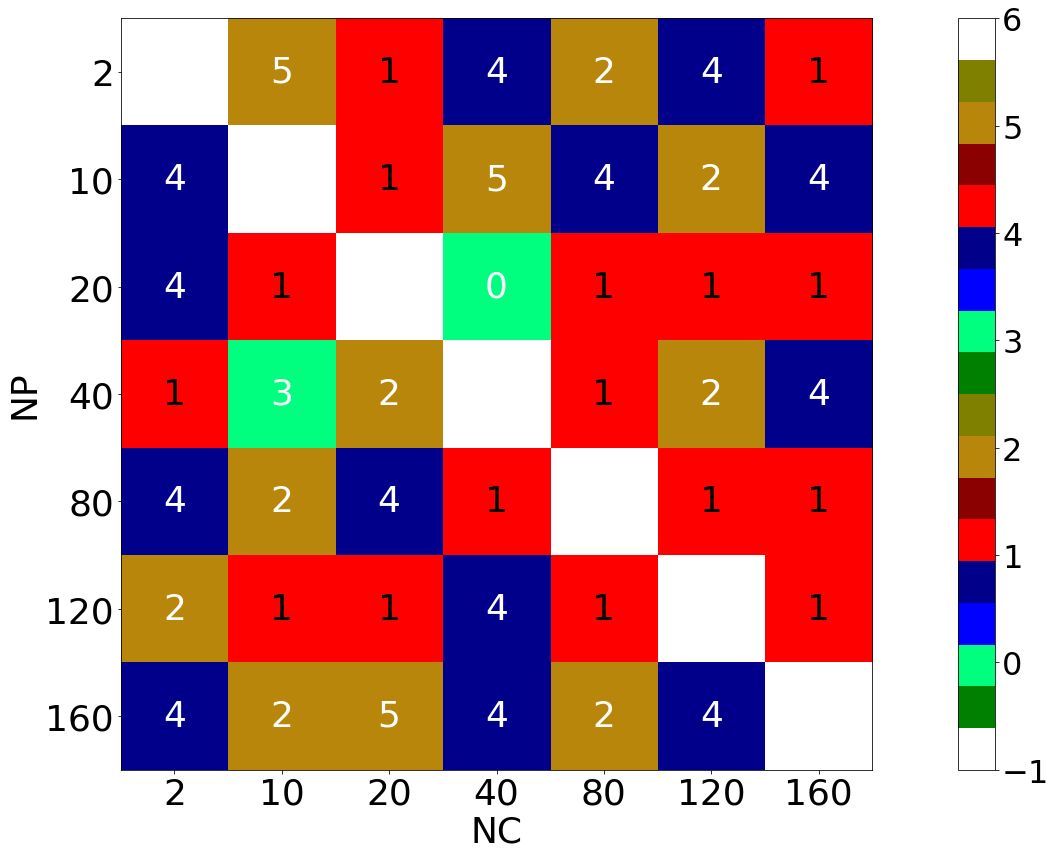

In [308]:
#Crea un heatmap teniendo en cuenta los colores anteriores
f=plt.figure(figsize=(24, 12))
ax=f.add_subplot(111)

myColors = (colors.to_rgba("white"),colors.to_rgba("green"), colors.to_rgba("springgreen"),colors.to_rgba("blue"),colors.to_rgba("darkblue"),
            colors.to_rgba("red"),colors.to_rgba("darkred"),colors.to_rgba("darkgoldenrod"),colors.to_rgba("olive"),
            colors.to_rgba("green"), colors.to_rgba("springgreen"),colors.to_rgba("blue"),colors.to_rgba("darkblue"),
            colors.to_rgba("red"),colors.to_rgba("darkred"),colors.to_rgba("darkgoldenrod"),colors.to_rgba("olive"),colors.to_rgba("white"))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

im = ax.imshow(heatmap,cmap=cmap,interpolation='nearest')

# Loop over data dimensions and create text annotations.
used_aux=0
for i in range(len(processes)):
    for j in range(len(processes)):
        if i!=j:
            aux_color="white"
            if heatmap[i, j] == 1: # El 1 puede necesitar texto en negro
                aux_color="black"
            results_index = i*len(processes) +j-used_aux
            if len(results_str[results_index]) == 1:
                text = results_str[results_index][0]
                ax.text(j, i, text, ha="center", va="center", color=aux_color, fontsize=36)
            else:
                add_aux = 0.33
                for line in range(len(results_str[results_index])):
                    i_range = i - 0.5 + add_aux
                    ax.text(j, i_range, results_str[results_index][line],
                            ha="center", va="center", color=aux_color, fontsize=36)
                    add_aux+=0.33
        else:
            used_aux+=1

ax.set_ylabel("NP", fontsize=36)
ax.set_xlabel("NC", fontsize=36)

ax.set_xticklabels(['']+processes, fontsize=36)
ax.set_yticklabels(['']+processes, fontsize=36)


#labelsMethods_aux = ['Baseline - AllS (0)', 'Invalid (1)','Baseline - P2PS (2)','Invalid (3)',
#                    'Merge -AllS (4)','Invalid (5)','Merge -P2PS (6)','Invalid(7)',
#                    'Baseline - AllA (8)', 'Baseline - AllT (9)','Baseline - P2PA (10)','Baseline - P2PT (11)',
#                    'Merge -AllA (12)','Merge - AllT (13)','Merge -P2PA (14)','Merge - P2PT (15)']
colorbar=f.colorbar(im, ax=ax)
tick_bar = []
for i in range(len(configurations)):
    tick_bar.append(0.35 + i*0.95) #TE
#colorbar.set_ticks(tick_bar) 
#colorbar.set_ticklabels(labelsMethods_aux)
colorbar.ax.tick_params(labelsize=32)
#

f.tight_layout()
f.savefig("Images/Spawn/Heatmap_"+tipo+".png", format="png")

In [253]:
a=[0,1,2,3,4]
b=a
count=3
a[2]=100
print(a)
print(b)

[0, 1, 100, 3, 4]
[0, 1, 100, 3, 4]


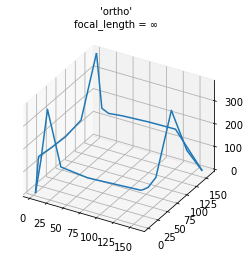

In [114]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

# Get the test data
#X, Y, Z = axes3d.get_test_data(0.05)

aux = grouped_aggG.loc[u_sols[0],'T_total']
Z = [None] * len(processes)
X, Y = np.meshgrid(processes, processes)
removed_index = 0
for i in range(len(processes)):
    Z[i] = [0] * len(processes)
    for j in range(len(processes)):
        if i!=j:
            real_i = i - removed_index
            real_j = j - removed_index
            Z[i][j] = aux.values[real_i*len(processes)+real_j]
        else:
            Z[i][j] = 0
            removed_index += 1  
Z = np.array(Z)

ax.plot_wireframe(X, Y, Z, rstride=20, cstride=10)
ax.set_proj_type('ortho')  # FOV = 0 deg
ax.set_title("'ortho'\nfocal_length = ∞", fontsize=10)
plt.show()